# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Fabio Deo
 - Net-id: fd232
 - Date: 09/28/2022
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment): 1
 - People with whom you discussed this assignment: 0

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/7tFZUoDszbDeDKmV6 and include the survey completion code below.

### Question 0 [2 points]
<font color='blue'> Survey completion code:  hw22022xyz

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='blue'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

To generate a set of recommended items, StitchFixes uses clients' free text description of their preferences in pieces of clothing. They also use the number of clothing attributes the customer has.
For cold starts, they use latent features infferred from previous orders and reviews to find customers with similar taste to the new user.

<font color='blue'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

The affinity between a customer and a stylist is the output of a model that takes into account many factors, such as the previous interactions between the two and the compatibility of the preferences of the customer with the style of the stylist. This affinity score is just one of the components that is used to output a final match, StitchFix also takes into account other features like distance (prioritizing matches in the close areas) and the work schedule of the stylist. 

The way StitchFix approaches matching is quite similar to how ride sharing apps like Uber match drivers with clients, as seen in class.

<font color='blue'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

To ensure that have enough material at all times, StitchFix uses a Markov chain model to predict future orders.
To maximise profict and optimize storage space they ran optimization models to order just enough resources, which 
allows them to not order an excess of material that would overload warehouses, while still having enough material to account for future orders, which could be made by new users but also be new pieces of clothing.

# Programming component

## Helper code

In [99]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle

def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'interaction'):
    ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return ratings, book_vectors, user_vectors

### Custom Printing functions

In [100]:
from IPython.display import display_html
from itertools import chain,cycle

def display_sbs(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h4 style="text-align: center; padding-bottom: 10px">{title}</h4>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    

In [101]:
def linear_plot_with_avg(x, y, ax, title = "", xlab = "", ylab = ""):
    # Colours for avg and line
    avg_colour = '#b3cde0'
    line_colour = '#005b96'
    
    # Compute average of y
    avg_rank = round(y.mean(), 2)
    
    # Plot line and average
    ax.plot(x, y, c = line_colour)
    ax.axhline(y = avg_rank, color = avg_colour, linewidth = 4, label = "avg rank =  " + str(avg_rank))

    # Set labels, title and legend
    ax.set_xlabel(xlab,  fontsize = 16)
    ax.set_ylabel(ylab,  fontsize = 16)
    ax.set_title(title,  fontsize = 20, fontweight="bold")
    ax.legend(fontsize = 16)



In [102]:
from matplotlib.patches import Rectangle


def hist_with_percentiles(data, ax, title = "", xlab = "", ylab = "", all_xticks = False):

    # Colours for different percentiles
    perc_50_colour = '#b3cde0'
    perc_75_colour = '#6497b1'
    perc_95_colour = '#005b96'
    perc_more95_colour = '#03396c'

    counts, bins, patches = ax.hist(data, bins = np.sort(np.unique(data)),  \
                                    facecolor = perc_50_colour, edgecolor='gray')

    # Set the ticks for each bin.
    if all_xticks:
        ax.set_xticks(bins.round(2))

    # Set the graph title and axes titles
    ax.set_title(title, fontsize = 20, fontweight="bold")
    ax.set_xlabel(xlab, fontsize = 16)
    ax.set_ylabel(ylab, fontsize = 16)

    # Change the colors of bars at the edges
    fifthy, seventyfifth, ninetyfifth = np.percentile(data, [50, 75, 95])
    
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside <= fifthy:
            patch.set_facecolor(perc_50_colour)
        elif leftside <= seventyfifth:
            patch.set_facecolor(perc_75_colour)
        elif leftside <= ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        else:
            patch.set_facecolor(perc_more95_colour)

    #create legend
    handles = [Rectangle((0, 0), 1, 1, color = c, ec = "k") for c in  \
               [perc_50_colour, perc_75_colour, perc_95_colour, perc_more95_colour]]
    
    labels = ["0-50 Percentile", "50-75 Percentile", "75-95 Percentile", ">95 Percentile"]
    ax.legend(handles, labels, fontsize = 16)

    # Display the graph
    plt.show()

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. 

Here, we work with multiple types of interactions as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 4 types of rating/interaction data:

 - `Interaction`: a "1" indicates the user has interacted with the book at some point in the past, either by saying that they intend to read it, have read it, or have given it a rating. If it is missing, that means the user has not interacted with the book.
 
 - `Explicit Rating`: explicit ratings. Numeric values indicate the ratings given. If it is missing, that means the user has not rated the book.
  
 - `Rating_all_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," so that there are no missing ratings.
 
 - `Rating_interaction_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," only if the user interacted with that book in the past.

In [103]:
ratings_interactions, book_vectors_interactions, user_vectors_interactions = load_ratings_and_factors(type_name = 'interaction')
ratings_explicit, book_vectors_explicit, user_vectors_explicit = load_ratings_and_factors(type_name = 'rating')
ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
ratings_interact0, book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')


In [104]:
def get_shapes_and_ranges(ratings, book_vectors, item_vectors):
    print(len(ratings), np.shape(book_vectors), np.shape(item_vectors), min(ratings.values()), max(ratings.values()))

In [105]:
get_shapes_and_ranges(ratings_interactions, book_vectors_interactions, user_vectors_interactions)
get_shapes_and_ranges(ratings_explicit, book_vectors_explicit, user_vectors_explicit)
get_shapes_and_ranges(ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(ratings_interact0, book_vectors_interact0, user_vectors_interact0)

12238 (200, 10) (1000, 10) 1 1
8324 (200, 10) (1000, 10) 1 5
200000 (200, 10) (1000, 10) 0 5
12238 (200, 10) (1000, 10) 0 5


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='blue'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

*Rating_interaction_zero* conveys a meaningful value for each pair user-book when the user has at least interacted with the book.

That tries to improve on Explicit Rating that does not deal with missing values, since if a user has interacted with the book in the past but has not rated it should convey a different information than if the user has never even interacted with the book.

<font color='blue'> What are some potential problems you see with using `rating_all_zero` for recommendations? Answer in no more than 3 sentences.
    
    

*rating_all_zero* replaces non-explicit ratings with zeros. 
Since users have likely not read and explicitly rated the majority of books, maybe for a set of 200 books yes but surely for pools of thousands of books, forcing to zero all ratings would massively bias the recommendation system, forcing the average book rating super close to zero for books that are not super popular.

### 1b) Generating predictions

<font color='blue'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [106]:
def get_predictions(user_vectors, book_vectors):
    pred_mat = np.dot(user_vectors, np.swapaxes(book_vectors, 0, 1))
    return pred_mat

<font color='blue'> Output the predictions for first 10 items for the first user, using each of the 4 data types.

For example, the predictions for one of the data types are:

Ratings for first 10 items,  interactions:
[-0.003  0.01   0.002 -0.001  0.003  0.007 -0.01   0.007  0.001  0.003]

In [107]:
pred_mat_interactions = get_predictions(user_vectors_interactions, \
                                        book_vectors_interactions)

pred_mat_explicit = get_predictions(user_vectors_explicit, \
                                    book_vectors_explicit)

pred_mat_allmissing0 = get_predictions(user_vectors_allmissing0, \
                                       book_vectors_allmissing0)

pred_mat_interact0 = get_predictions(user_vectors_interact0, \
                                     book_vectors_interact0)

In [108]:
first_user_10items_ratings = pd.DataFrame(columns = ['User', 'Items', 'Data Type', "Ratings"])
combined_pred_mats = [pred_mat_interactions[0, :10], pred_mat_explicit[0, :10], \
                      pred_mat_allmissing0[0, :10], pred_mat_interact0[0, :10]]

datatypes = ["Interactions", "Explicit", "AllMissing0", "Interact0"]
for dt, pred_mat in zip(datatypes, combined_pred_mats):

     first_user_10items_ratings = first_user_10items_ratings.append({ \
                            'User' : 1, 
                            'Items': "1-10", 
                            'Data Type': dt,
                            'Ratings': np.around(pred_mat, decimals = 3) \
                         }, ignore_index = True \
                         )
display_sbs(first_user_10items_ratings, titles = ['First User Ratings for the first 10 items'])

,User,Items,Data Type,Ratings
0,1,1-10,Interactions,"[-0.003, 0.01, 0.002, -0.001, 0.003, 0.007, -0.01, 0.007, 0.001, 0.003]"
1,1,1-10,Explicit,"[0.073, 0.407, 0.076, -0.075, 0.176, 0.959, -0.239, -0.002, -0.912, 0.658]"
2,1,1-10,AllMissing0,"[0.08, 0.29, 0.063, 1.57, -0.186, 0.055, 0.011, -0.088, -0.895, -0.012]"
3,1,1-10,Interact0,"[-1.009, 4.167, -0.919, -0.302, -2.526, -0.189, -3.081, -0.537, -1.186, -1.218]"


<font color='blue'> Do a scatterplot of the predicted rating for the "interaction" and "explicit ratings" types. (Each dot represents one user and one book, with X axis being predicted ratings using interaction data and Y axis being predicted rating using explicit ratings). Describe what you see in no more than 2 sentences. 

The scatterplot clearly shows that Interaction predictions cluster super close to zero, while Explicit predictions have significant higher variance. 

That conveys the idea that customer interactions do not give a clear indication on how much they could enjoy that item, while explicit ratings offer a much clearer indication.

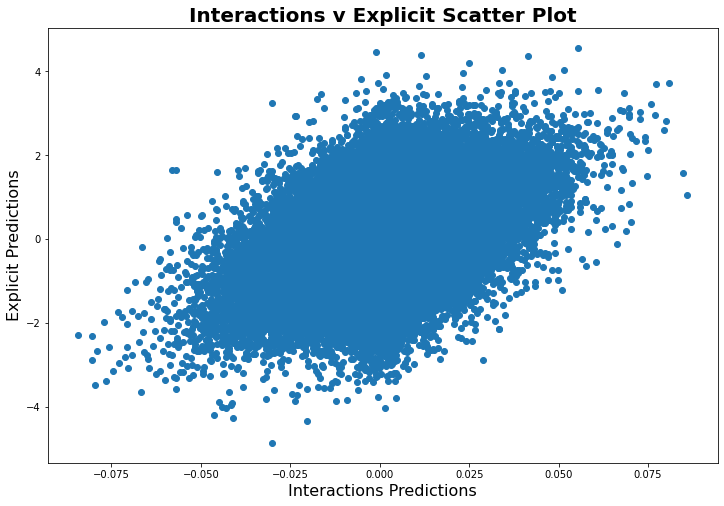

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.scatter(pred_mat_interactions.reshape(1, -1)[0], pred_mat_explicit.reshape(1, -1)[0])

ax.set_xlabel("Interactions Predictions", fontsize = 16)
ax.set_ylabel("Explicit Predictions", fontsize = 16)
ax.set_title("Interactions v Explicit Scatter Plot", fontsize = 20, fontweight="bold")

plt.show()

### 1c) From predictions to recommendations (without capacity constraints)

<font color='blue'> Fill in the following function that takes in the matrix of predicted ratings for each user and item, and returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [110]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    recom_dict = {}
    recom_values = np.empty((0, number_top_items))
    for user_id, user_row in enumerate(predictions):
        unsorted_top_recom_idxs = np.argpartition(user_row, -number_top_items)[-number_top_items:]
        sorted_top_recom_idxs = unsorted_top_recom_idxs[np.argsort(user_row[unsorted_top_recom_idxs])][::-1]
        
        recom_dict[user_id] = sorted_top_recom_idxs
        recom_values = np.append(recom_values, user_row[sorted_top_recom_idxs].reshape(1, number_top_items), \
                                 axis = 0)

    return recom_dict

<font color='blue'> Output the recommendations for the first user, using each of the 4 data types.

For example, from the "Interaction" dataset, you should get: [182, 198, 19, 100, 104, 73, 30, 199, 164, 74]

In [111]:
top_items = 10
recom_interaction = get_recommendations_for_each_user(pred_mat_interactions, top_items)
recom_explicit = get_recommendations_for_each_user(pred_mat_explicit, top_items)
recom_allmissing0 = get_recommendations_for_each_user(pred_mat_allmissing0, top_items)
recom_interact0 = get_recommendations_for_each_user(pred_mat_interact0, top_items)

In [112]:
uid = 1
first_user_top10items = pd.DataFrame(columns = ['User', 'Data Type', "Recommended Items"])
combined_recom_mats = [recom_interaction, recom_explicit, recom_allmissing0, recom_interact0]

datatypes = ["Interactions", "Explicit", "AllMissing0", "Interact0"]
for dt, recom_mat in zip(datatypes, combined_recom_mats):

     first_user_top10items = first_user_top10items.append({ \
                            'User' : 1, 
                            'Data Type': dt,
                            'Recommended Items': recom_mat[uid] \
                         }, ignore_index = True \
                         )
display_sbs(first_user_top10items, titles = ['Top 10 items recommended for the first user'])

,User,Data Type,Recommended Items
0,1,Interactions,"[182, 171, 79, 102, 198, 161, 125, 76, 1, 140]"
1,1,Explicit,"[150, 123, 95, 115, 109, 0, 191, 136, 21, 7]"
2,1,AllMissing0,"[80, 57, 63, 50, 78, 86, 81, 77, 98, 96]"
3,1,Interact0,"[126, 121, 70, 67, 193, 16, 137, 27, 166, 39]"


<font color='blue'> Fill in the following function that takes in the (top 10) recommendations for each user, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [113]:
def show_frequency_histograms(recommendations, ax, datatype = ""):
    recom_count = np.zeros(200)
    for k in recommendations:
        books_recom = recommendations[k]
        recom_count[books_recom] += 1
    
    recom_count_dict = {}
    for count in recom_count:
        if count in recom_count_dict:
            recom_count_dict[count] += 1
        else:
            recom_count_dict[count] = 1

    ax.bar(recom_count_dict.keys(), recom_count_dict.values())
    ax.set_xlabel("Recommendations Count", fontsize = 16)
    ax.set_ylabel("Number of Books",  fontsize = 16)
    ax.set_title("Histogram of " + datatype + " Recommended Books",  fontsize = 20,  fontweight = "bold")

<font color='blue'> Show the histograms for the "interact" and "explicit" data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

The two histograms are quite different. 

For Interactions data, the most recommended book appears in the top10 of almost 300 users, for Explicit instead, the most recommended book only appears in almost 200 top10s.

Because Interaction data has quite a few very popular books that are recommended more than 100 times, many books did not make it in any top10 (exactly 75 books), which is much less than in the Explicit data (only 10 books were not recommended to any user).

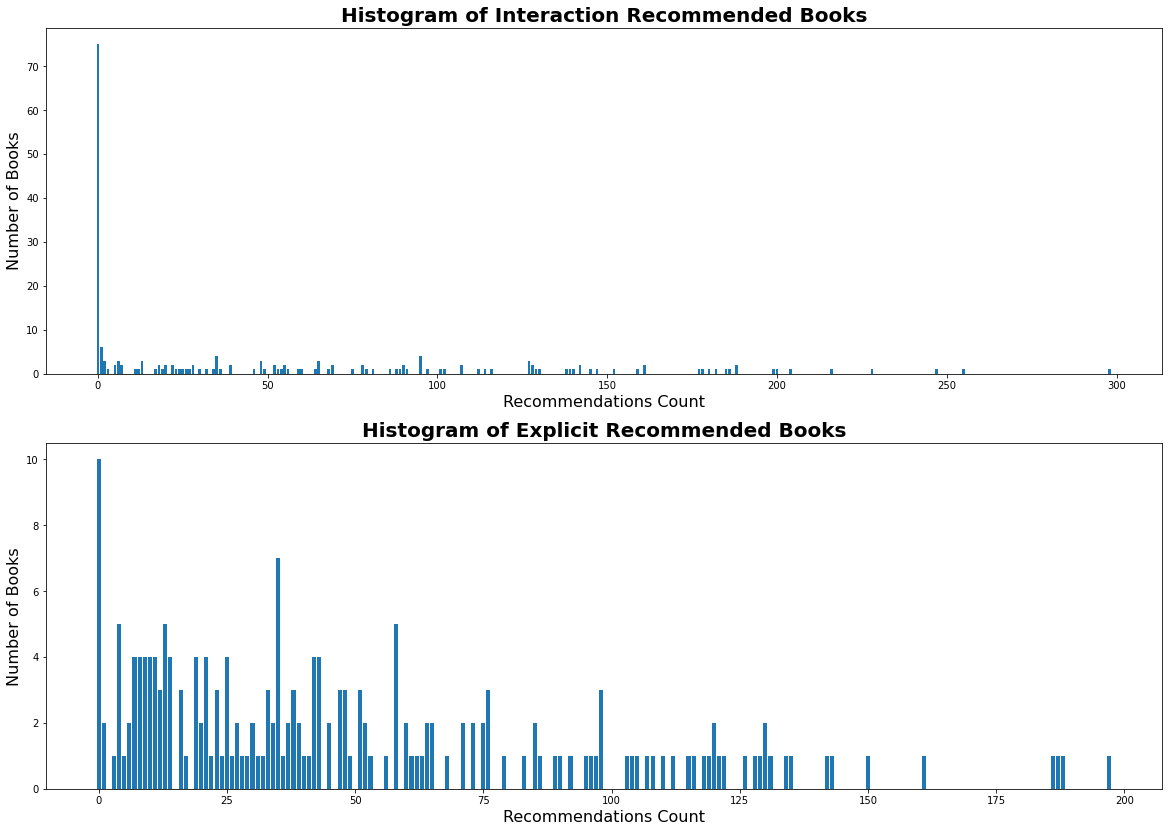

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))
show_frequency_histograms(recom_interaction, ax[0], "Interaction") 
show_frequency_histograms(recom_explicit, ax[1], "Explicit")

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [115]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the "ratings with interaction0" data.

In [116]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

For example, using this method, you should find that the vector for the second user (index "1") is:

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

In [117]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [118]:
med = existing_user_demographics.Wealth.median()

def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    wealthy_users = existing_user_demographics[existing_user_demographics["Wealth"] > med]["User ID"] - 1
    non_wealthy_users = existing_user_demographics[existing_user_demographics["Wealth"] <= med]["User ID"] - 1
    
    wealthy_mean_vec = existing_user_vectors[wealthy_users, :].mean(axis = 0)
    non_wealthy_mean_vec = existing_user_vectors[non_wealthy_users, :].mean(axis = 0)
    
    return wealthy_mean_vec if new_user.Wealth > med else non_wealthy_mean_vec

<font color='blue'> Output the mean vector predicted for the first user (index 0) in `new_user_demographics`. 

In [119]:
new_user0_vect = get_user_vector_for_new_user(new_user_demographics.iloc[0], \
                                             existing_user_demographics, existing_user_vectors)
new_user1_vect = get_user_vector_for_new_user(new_user_demographics.iloc[1], \
                                             existing_user_demographics, existing_user_vectors)


In [120]:
new_user_vect_df = pd.DataFrame(columns = ['User', 'New Vector'])

for uid, new_vect in zip([0, 1], [new_user0_vect, new_user1_vect]):

     new_user_vect_df = new_user_vect_df.append({ \
                            'User' : uid, 
                            'New Vector': np.around(new_vect, decimals = 3) \
                         }, ignore_index = True \
                         )
display_sbs(new_user_vect_df, titles = ['Cold Start New User Vector for User 0 and 1'])

,User,New Vector
0,0,"[0.088, -0.207, -0.178, -0.131, -0.089, -0.127, -0.122, -0.427, -0.058, -0.106]"
1,1,"[-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02, 0.137, -0.12, 0.022]"


### 2b) [Bonus, 3 points] Predictions for new users [Using KNN or another model]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> Now, use K nearest neighbors or some other machine learning method. 
    
<font color='blue'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [121]:
all_user_demographics = pd.concat([existing_user_demographics, new_user_demographics])

age_levels = ['18 to 34', '35 to 49', '50 to 64', '65 and older']

all_user_demographics['Age class'] = all_user_demographics.apply(
    lambda x:  age_levels.index(x["Age group"]),
    axis=1)

all_user_demographics.drop(columns = ["Age group"], inplace = True)
all_user_demographics = pd.get_dummies(all_user_demographics)


X = all_user_demographics[:len(existing_user_demographics)]
X_test = all_user_demographics[len(existing_user_demographics):]

Y = existing_user_vectors


In [122]:
from sklearn.neighbors import KNeighborsRegressor
nn = 10
weight_func = "distance"

neigh = KNeighborsRegressor(n_neighbors = nn, weights = weight_func)
neigh.fit(X, Y)

def get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors):
    return neigh.predict(new_user)

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [123]:
knn_user_vector_pred = get_user_vector_for_new_user_knn(X_test, existing_user_demographics, \
                                                        existing_user_vectors)

knn_predict_df = pd.DataFrame(columns = ['User', 'Predicted Vector'])

knn_predict_df = knn_predict_df.append({ \
                    'User' : 1, 
                    'Predicted Vector': np.around(knn_user_vector_pred[0], decimals = 3) \
                 }, ignore_index = True \
                 )
display_sbs(knn_predict_df, titles = ['Vector Predicted For First User by KNN' + str(nn) + "-" + weight_func])

,User,Predicted Vector
0,1,"[0.042, 0.192, -0.542, 0.163, -0.178, -0.186, 0.247, 0.188, 0.161, -0.146]"


<font color='blue'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

I am using a sklearn KNN Regressor. As such, I made the two following architectural choices:
- Nearest Neighbors = 10: I used 10 neighbors since it is important to add a bit of variance against outliers, the closest user from a demographic standpont might be actually quite far in terms of taste similarities to the new user. 
- Distance Function = "Distance": The options sklearn gives for weights function are two ("Uniform" or "Distance"). I used "Distance" since it weights more closer neighbors which makes sense to improve prediction as they are more likely to better map the preferences of the new user, while "Uniform" weights all neighbors equally.

### 2c) Comparing predictions from "true" user vector and from above

<font color='blue'> For each of the 100 "new" users, use either your model from 2a or 2b ("demographic model") to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. First, plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

For example, for the first user-item pair (index 0 user, index 0 user), your prediction using the basic demographic should be -0.0011902780252621872, and using the full model should be 0.31447640890118356. So one point in the scatter plot would be (-0.0011902780252621872, 0.31447640890118356).

In [124]:
new_user_vectors_2a = []
for _, new_user in new_user_demographics.iterrows():
    new_user_vectors_2a.append(
        get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors)
    )

new_user_vectors_2b = knn_user_vector_pred

In [125]:
rating_predictions_2a = get_predictions(new_user_vectors_2a, book_vectors_interact0)
rating_predictions_2b = get_predictions(new_user_vectors_2b, book_vectors_interact0)

new_user_vec_interact0_2a = rating_predictions_2a
new_user_vec_interact0_1full = pred_mat_interact0[900:]


first_new_user_interact0 = pd.DataFrame(columns = ['User', 'Item', '2A Model', '1Full Model'])

first_new_user_interact0 = first_new_user_interact0.append({ \
                    'User' : '0', 
                    'Item': '0',
                    '2A Model': new_user_vec_interact0_2a[0, 0],
                    '1Full Model': new_user_vec_interact0_1full[0, 0] \
                 }, ignore_index = True \
                 )
display_sbs(first_new_user_interact0, \
            titles = ["Prediction for 2A Model and 1Full Model"])

,User,Item,2A Model,1Full Model
0,0,0,-0.00119,0.314476


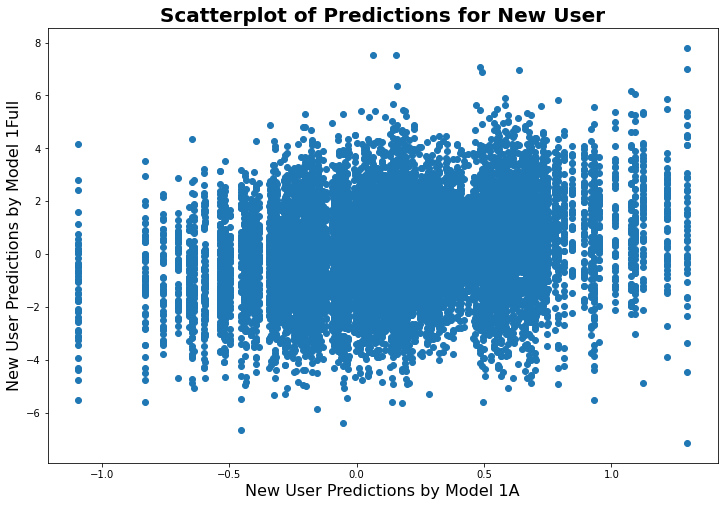

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.scatter(new_user_vec_interact0_2a, new_user_vec_interact0_1full)

ax.set_xlabel("New User Predictions by Model 1A", fontsize = 16)
ax.set_ylabel("New User Predictions by Model 1Full",  fontsize = 16)
ax.set_title("Scatterplot of Predictions for New User",  fontsize = 20,  fontweight = "bold")
plt.show()

<font color='blue'> Now for each new user, calculate the mean rating (according to the "full" model in Problem 1) for the 10 items recommended to that user, by each of the demopgraphic and "full" models. Output a scatterplot for the two mean ratings, where each point correpsonds to 1 user (and so you will have 100 points in your scatter plot). For example, for the first new user, the associated point is (2.4880867541832146, 0.5305243424156764). 

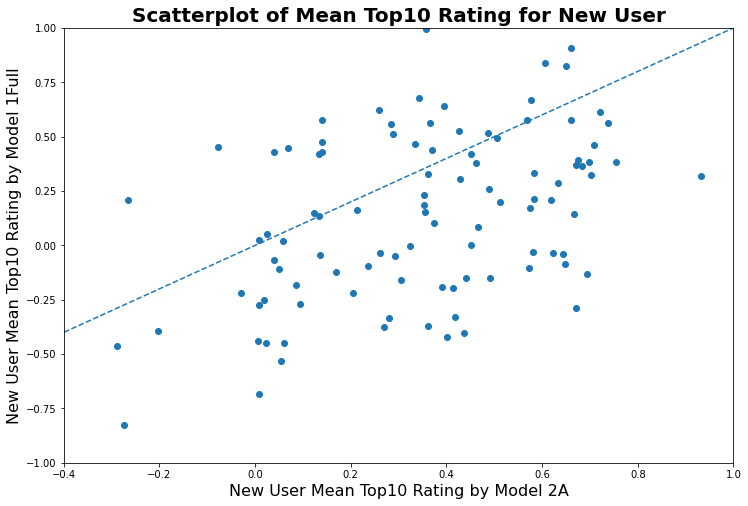

In [127]:
new_user_vec_interact0_2a_means = []
for i in range(900, 1000):
    new_user_vec_interact0_2a_means.append(new_user_vec_interact0_2a[i - 900, recom_interact0[i]].mean())


fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.scatter(new_user_vec_interact0_2a_means, new_user_vec_interact0_1full.mean(axis = 1))

ax.set_xlabel("New User Mean Top10 Rating by Model 2A", fontsize = 16)
ax.set_ylabel("New User Mean Top10 Rating by Model 1Full", fontsize = 16)
ax.set_title("Scatterplot of Mean Top10 Rating for New User", fontsize = 20, fontweight = "bold")

x = np.linspace(-1,1,10)
ax.plot(x, x, '--')

ax.set_xlim(-0.4, 1)
ax.set_ylim(-1, 1)


plt.show()

<font color='blue'> Comment on the above. What is the "loss" from using demogprahics since we do not have access to the full data?

The scatterplot clearly shows that in using the demographics model instead of the full model the predictions significantly vary. Ideally, the mean rating for the Top10 books should be very similar (i.e. close to the dashed line) since everything demographic does is predicting the user vector that are given in the full model.

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='blue'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='blue'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
For example, you'll see that the first user was recommended their favorite item, but the last user was recommended their 129th favorite item. 


<font color='blue'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

In [128]:
taken_books = {}
user_to_rank = {}
recom_interact0_allbooks = get_recommendations_for_each_user(pred_mat_interact0, 200)
for user_id in recom_interact0_allbooks:
    for rank, book in enumerate(recom_interact0_allbooks[user_id]):
        if book in taken_books and taken_books[book] == 5:
            continue
        
        if book not in taken_books:
            taken_books[book] = 1  
        else :
            taken_books[book] += 1  
        
        user_to_rank[user_id] = rank + 1
        break    

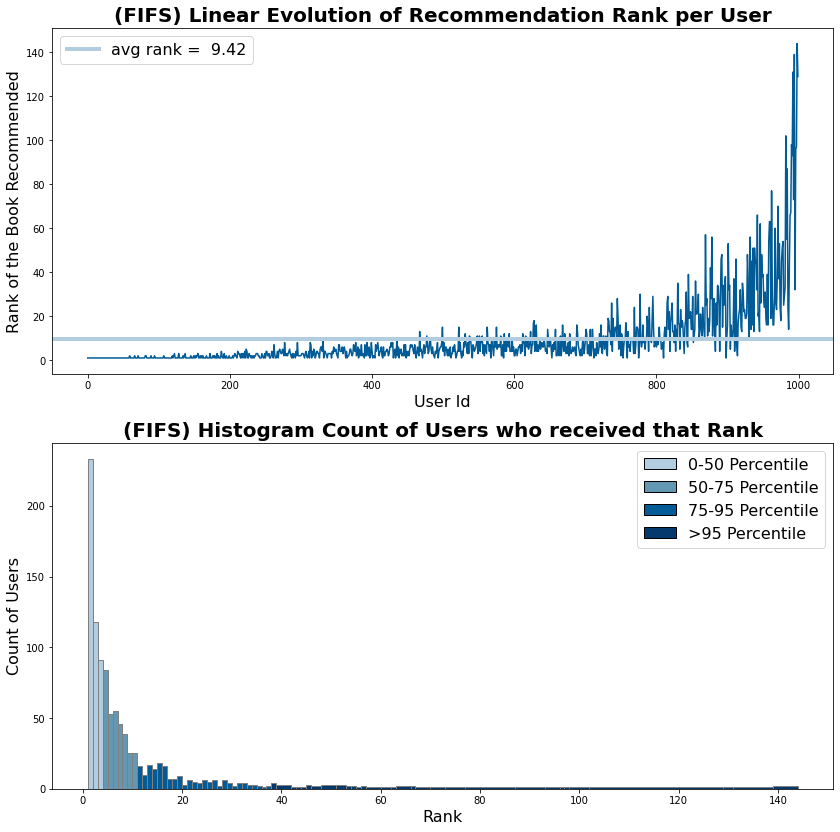

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
users, ranks = zip(*user_to_rank.items()) 

linear_plot_with_avg(users, np.array(ranks), ax[0], \
                     title ="(FIFS) Linear Evolution of Recommendation Rank per User", \
                     xlab = "User Id", ylab = "Rank of the Book Recommended")

            
hist_with_percentiles(ranks, ax[1], title = "(FIFS) Histogram Count of Users who received that Rank", \
                      xlab = "Rank", ylab = "Count of Users")

plt.show()

### 3b) [Bonus -- 4 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[2 points] <font color='blue'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='blue'> Describe what you observe compared to the naive recommendations above. 
    
<font color='blue'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

For the first plot (sequential recommendation ranks per user) is evident from the comparison of the two plots that the first uses a First Come First Serve approach while the second minimises the average rank. I plotted the average rank as an horizontal line in both plots to show that the optimized version achieves a way better average result with the 4.51 booked being recommended on average vs the 9.42 book for the sequential version.

For the histogram plot, I have colored bars to show percentiles. That nicely conveys that while both models assign the first choice to roughly the same number of users, in the optimized version 95% of the users got one of their top 7 choices, while in the sequential one the 95th percentile goes up to the 37th choice.

In [130]:
cost_matrix = np.empty((0, 1000))

for user_id in recom_interact0_allbooks:
    cost_array = np.zeros(200)
    cost_array[recom_interact0_allbooks[user_id]] = list(range(1, 201))
    cost_array = np.tile(cost_array, 5)
    cost_matrix = np.append(cost_matrix, cost_array.reshape(1, -1), axis=0)

from scipy.optimize import linear_sum_assignment
user_ids, book_ids = linear_sum_assignment(cost_matrix)


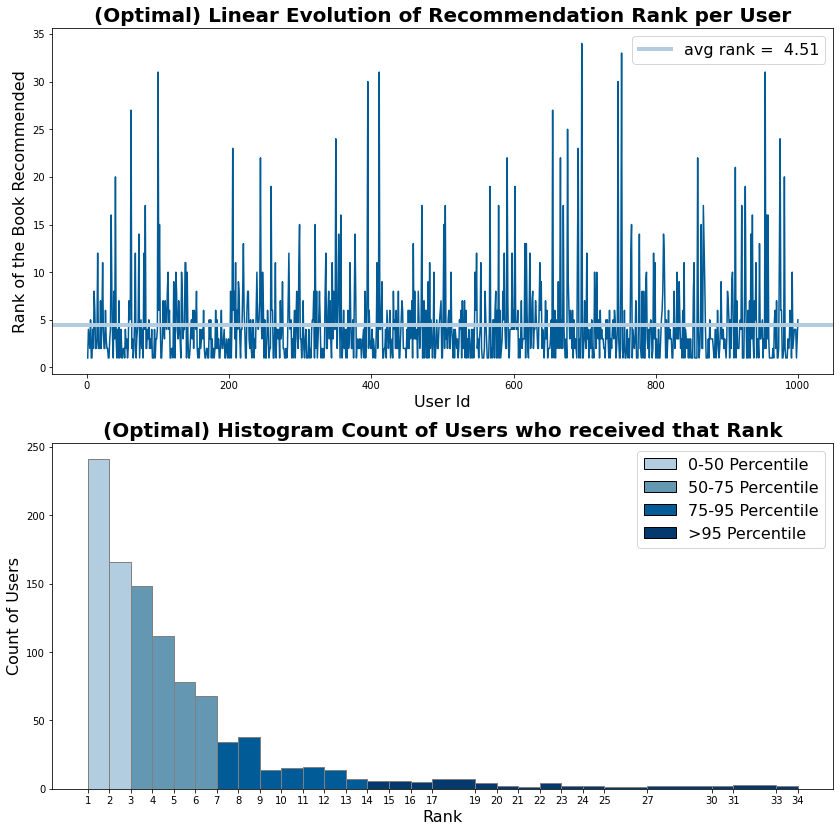

In [131]:
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
ranks = cost_matrix[user_ids, book_ids] 
users = list(range(1, 1001))

linear_plot_with_avg(users, ranks, ax[0], title ="(Optimal) Linear Evolution of Recommendation Rank per User", \
                     xlab = "User Id", ylab = "Rank of the Book Recommended")

hist_with_percentiles(ranks, ax[1], title = "(Optimal) Histogram Count of Users who received that Rank", \
                      xlab = "Rank", ylab = "Count of Users", all_xticks = True)

plt.show()

[2 points] <font color='blue'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='blue'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

In [141]:
cost_matrix = np.empty((0, 1000))
books_taken = {}

all_ranks = np.array([])


for i, user_id in enumerate(recom_interact0_allbooks):
    cost_array = np.zeros(200)
    cost_array[recom_interact0_allbooks[user_id]] = list(range(1, 201))
    cost_array = np.tile(cost_array, 5)
    
    for b in books_taken:
        cost_array[b] = 200
            
    cost_matrix = np.append(cost_matrix, cost_array.reshape(1, -1), axis=0)
    
    if (i+1) % 100 == 0:
        user_ids, book_ids = linear_sum_assignment(cost_matrix)
        ranks = cost_matrix[user_ids, book_ids]
        all_ranks = np.append(all_ranks, ranks)
        for b in book_ids :
            books_taken[b] = 1
        cost_matrix = np.empty((0, 1000))


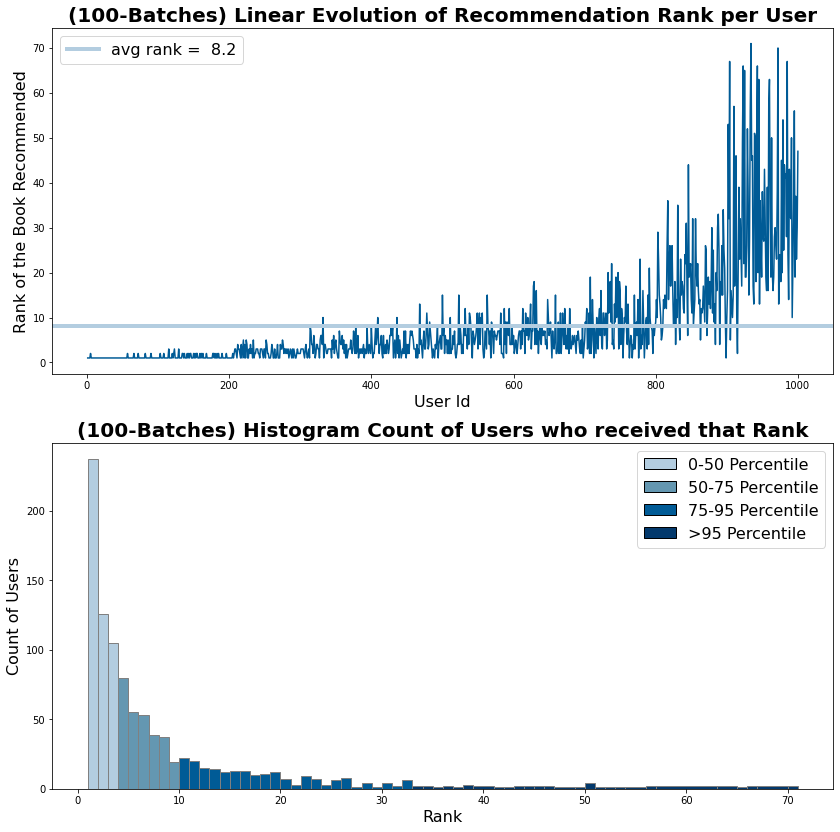

In [142]:
fig, ax = plt.subplots(2, 1, figsize=(14, 14))

users = list(range(1, 1001))

linear_plot_with_avg(users, all_ranks, ax[0], \
                     title ="(100-Batches) Linear Evolution of Recommendation Rank per User", \
                     xlab = "User Id", ylab = "Rank of the Book Recommended")

hist_with_percentiles(all_ranks, ax[1], title = "(100-Batches) Histogram Count of Users who received that Rank", \
                      xlab = "Rank", ylab = "Count of Users")

plt.show()

### 3c) Score functions for recommendations under capacity constraints

<font color='blue'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='blue'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='blue'> Implement the above and run the same simulation as part 3c, show the same two plots, and describe what you observe.

<font color='blue'> For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{j}}} \sqrt{C_j} $$

HINT: In your code, for each user $i$ you will:
1. Retrieve the ratings ${r_{ij}}$ for each item $j$. 
2. Normalize each  ${r_{ij}}$ for by mean item rating $r_j$ and multiply by the sqrt of the current capacity for that item. 
3. Sort the items by the above modified score, and recommend the best item according to the modified score.

As expected, scoring the books based on the mean rating of the book improves even more on the optimal recommendation algorithm implemented in part (3b), with an average rating of 4.1 compared to the 4.51 obtained in part (3b).

That is intuitively because sorting items after scoring them taking into account the mean rating of the book helps in making better recommendations.

In [143]:
pred_mat_interact0_scored = pred_mat_interact0.copy()

pred_mat_interact0_scored = (pred_mat_interact0_scored - pred_mat_interact0_scored.min()) / \
                     (pred_mat_interact0_scored.max() - pred_mat_interact0_scored.min())


for i, col in enumerate(pred_mat_interact0_scored.T):
    pred_mat_interact0_scored[:, i] = pred_mat_interact0_scored[:, i] / col.mean() 


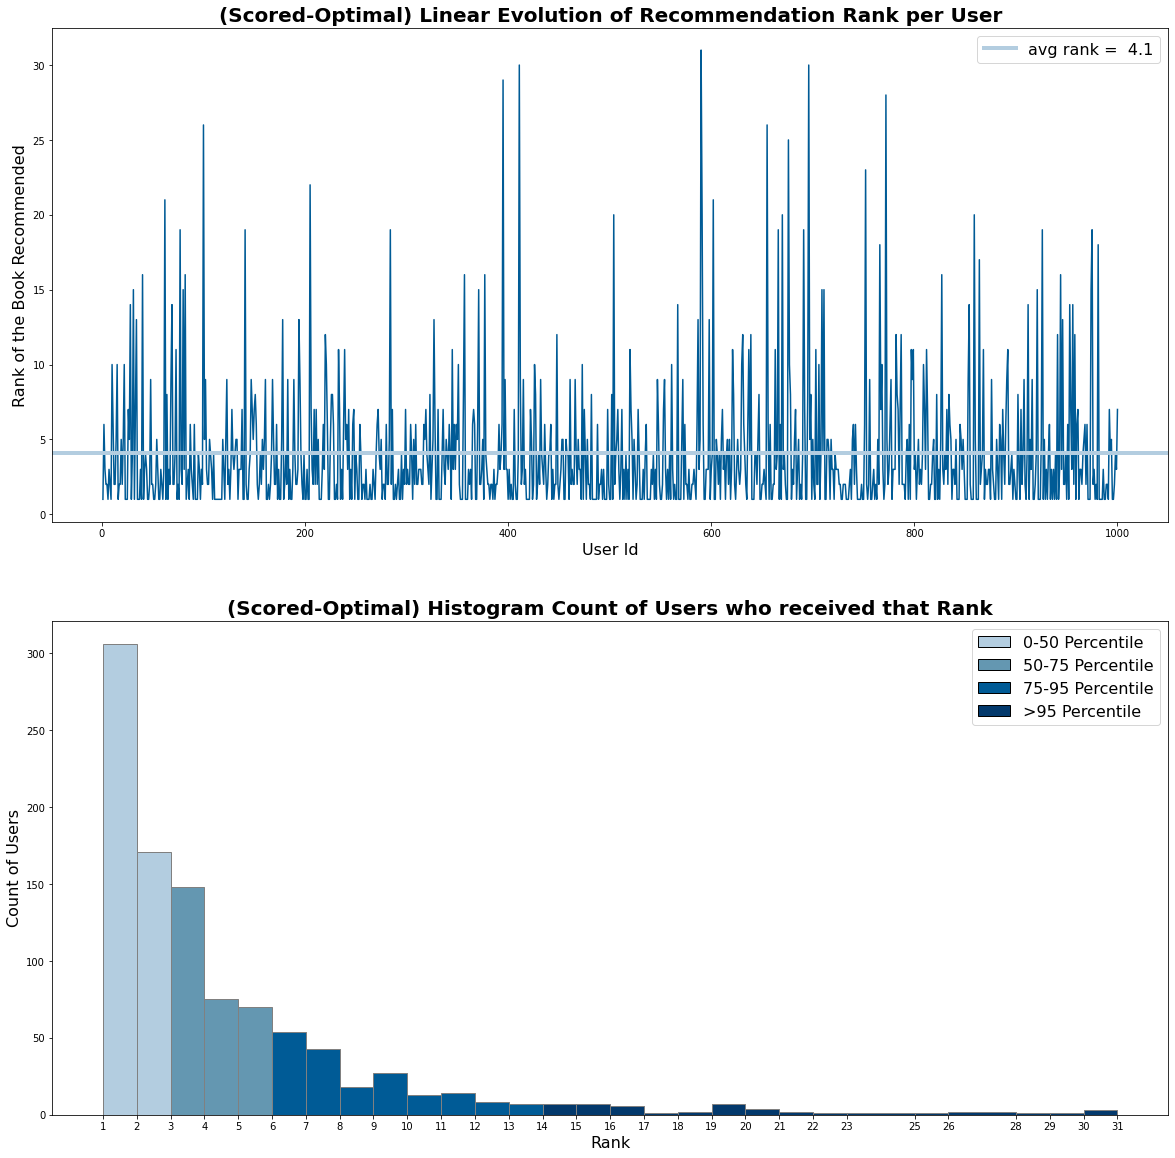

In [144]:
scored_recom_interact0_allbooks = get_recommendations_for_each_user(pred_mat_interact0_scored, \
                                                                    number_top_items = 200)

cost_matrix = np.empty((0, 1000))
for user_id in scored_recom_interact0_allbooks:
    cost_array = np.zeros(200)
    cost_array[scored_recom_interact0_allbooks[user_id]] = list(range(1, 201))
    cost_array = np.tile(cost_array, 5)
    cost_matrix = np.append(cost_matrix, cost_array.reshape(1, -1), axis=0)

user_ids, book_ids = linear_sum_assignment(cost_matrix)


fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ranks = cost_matrix[user_ids, book_ids] 
users = list(range(1, 1001))

linear_plot_with_avg(users, ranks, ax[0], \
                     title ="(Scored-Optimal) Linear Evolution of Recommendation Rank per User", \
                     xlab = "User Id", ylab = "Rank of the Book Recommended")

            
hist_with_percentiles(ranks, ax[1], title = "(Scored-Optimal) Histogram Count of Users who received that Rank", \
                      xlab = "Rank", ylab = "Count of Users", all_xticks = True)

plt.show()

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 